In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))


import gc


# Any results you write to the current directory are saved as output.

['the-movies-dataset', 'tmdb-movie-metadata']


In [24]:
data_rating = pd.read_csv('../input/the-movies-dataset/ratings.csv')
data_rating.head()
data_rating = data_rating[:1110000]
gc.collect()
print(len(data_rating))

1110000


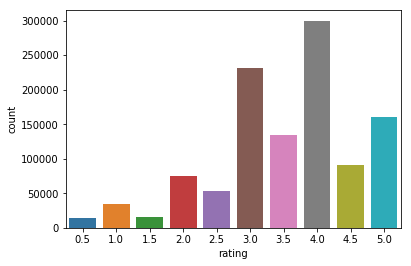

In [25]:

rating = data_rating['rating']
sn.countplot(rating)
plt.show()

In [26]:
from surprise import SVD, Reader, Dataset,evaluate

reader = Reader()
data = Dataset.load_from_df(data_rating[['userId','movieId','rating']], reader)

gc.collect()

2769

In [27]:
data.split(n_folds=3)
gc.collect()

0

In [28]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])
gc.collect()

/opt/conda/lib/python3.6/site-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/opt/conda/lib/python3.6/site-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8472
MAE:  0.6465
------------
Fold 2
RMSE: 0.8455
MAE:  0.6449
------------
Fold 3
RMSE: 0.8472
MAE:  0.6455
------------
------------
Mean RMSE: 0.8466
Mean MAE : 0.6456
------------
------------


0

In [29]:
trainset = data.build_full_trainset()
svd.fit(trainset)

gc.collect()

0

In [30]:
data_rating[data_rating['userId'] == 3]

,userId,movieId,rating,timestamp
49,3,480,3.0,1048076925
50,3,500,2.0,1048076945
51,3,527,4.0,1048076900
52,3,858,4.0,1048076945
53,3,1092,3.0,1048076995
54,3,1097,3.0,1048076961
55,3,1270,3.0,1048076976
56,3,1968,3.0,1048077048
57,3,3101,3.0,1048076830
58,3,4474,3.0,1048077030


In [31]:
svd.predict(1, 302, 3)
#gc.collect()

Prediction(uid=1, iid=302, r_ui=3, est=4.211270382065468, details={'was_impossible': False})

In [32]:
os.listdir('../input')
os.listdir('../input/tmdb-movie-metadata')

['tmdb_5000_credits.csv', 'tmdb_5000_movies.csv']

In [37]:
tmdb_data_cred = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
print(tmdb_data_cred.columns)

print()

tmdb_data_mov = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')
print(tmdb_data_mov.columns)

Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')


In [38]:
tmdb_data_cred.columns = ['id','tittle','cast','crew']
tmdb_data_mov = tmdb_data_mov.merge(tmdb_data_cred,on='id')

In [39]:
tmdb_data_mov.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [47]:
#on a scale of 10
C = tmdb_data_mov['vote_average'].mean()
C

6.092171559442011

In [48]:
val = tmdb_data_mov['vote_count'].quantile(0.85)
val

1300.6999999999998

In [49]:
#movies that qualify our 0.85 value
qual_movies = tmdb_data_mov.copy().loc[tmdb_data_mov['vote_count'] >= val]
qual_movies.shape

(721, 23)

In [52]:
""" weighted rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C where:
R = average for the movie (mean) = (Rating)
v = number of votes for the movie = (votes)
m = minimum votes required to be listed in the Top 250 (currently 25000)
C = the mean vote across the whole report (currently 7.0)
"""

def weig_range(x,m=val,C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v / (v+m) * R) + (m / (m+v) * C)
    


In [54]:
qual_movies['scores'] = qual_movies.apply(weig_range,axis=1)


In [57]:
qual_movies = qual_movies.sort_values('scores', ascending=False)

#Print the top 10 movies
qual_movies[['title', 'vote_count', 'vote_average', 'scores']].head(10)

,title,vote_count,vote_average,scores
1881,The Shawshank Redemption,8205,8.5,8.170528
662,Fight Club,9413,8.3,8.031958
3232,Pulp Fiction,8428,8.3,8.004820
65,The Dark Knight,12002,8.2,7.993903
3337,The Godfather,5893,8.4,7.982719
96,Inception,13752,8.1,7.926504
809,Forrest Gump,7927,8.2,7.902889
95,Interstellar,10867,8.1,7.885368
329,The Lord of the Rings: The Return of the King,8064,8.1,7.821125
1990,The Empire Strikes Back,5879,8.2,7.818138


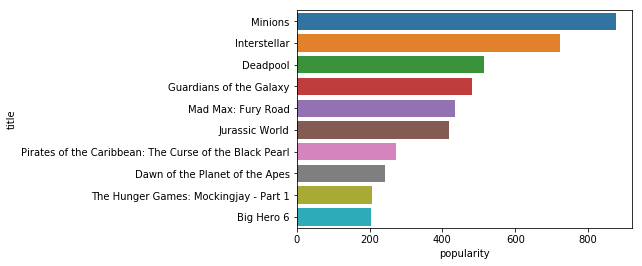

In [64]:
# TOP 10 MOVIES according to popularity

popular = tmdb_data_mov.sort_values('popularity',ascending= False)
sn.barplot(popular['popularity'].head(10),popular['title'].head(10))
plt.show()

